# Codelabs1: Text detection using Google Cloud Vision API

The Vision API runs OCR, similar to the model used in Google Translate, to extract the following text from the image and identify that the text is in English

The Vision API can detect and extract text from images. There are two annotation features that support optical character recognition:

* **TEXT_DETECTION:** detects and extracts text from any image. For example, a photograph might contain a street sign or traffic sign. The JSON includes the entire extracted string, as well as individual words, and their bounding boxes. <div>



* **DOCUMENT_TEXT_DETECTION:** also extracts text from an image, but the response is optimized for dense text and documents. The JSON includes page, block, paragraph, word, and break information. <div>






<img src = "./img/cloud_ml_ocr.png" width=720>

In [2]:
!pip3 install google

In [4]:
from google.cloud import vision
from google.cloud.vision import types
import io
from PIL import Image, ImageDraw
from enum import Enum
import pandas as pd

## Input Image 

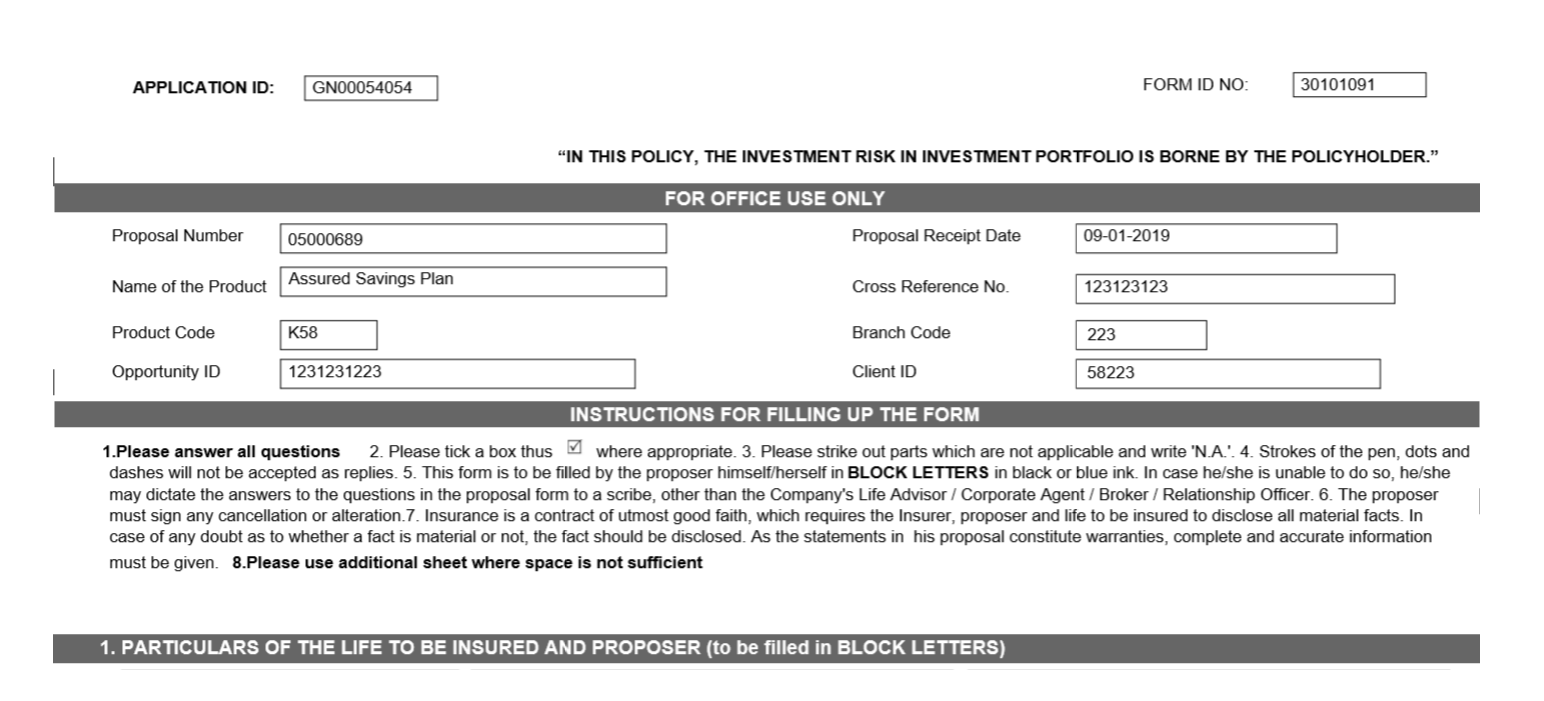

In [77]:
image_file='img/form.png'  ## printed data
# image_file='images/sample.png'    ## error data
# image_file='images/cloudML.png'    ## handwritten data


image  = Image.open(image_file)
image

# Calling the API



In [78]:
''' '''
client = vision.ImageAnnotatorClient()
with io.open(image_file, 'rb') as image_file1:
        content = image_file1.read()
content_image = types.Image(content=content)
response = client.document_text_detection(image=content_image)
document = response.full_text_annotation

# Plotting bounding boxes from the response.

In [79]:
class FeatureType(Enum):
    PAGE = 1
    BLOCK = 2
    PARA = 3
    WORD = 4
    SYMBOL = 5
    
def draw_boxes(image, bounds, color,width=5):
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        draw.line([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y,
            bound.vertices[0].x, bound.vertices[0].y],fill=color, width=width)
    return image

def get_document_bounds(response, feature):
    bounds=[]
    for i,page in enumerate(document.pages):
        for block in page.blocks:
            if feature==FeatureType.BLOCK:
                bounds.append(block.bounding_box)
            for paragraph in block.paragraphs:
                if feature==FeatureType.PARA:
                    bounds.append(paragraph.bounding_box)
                for word in paragraph.words:
                    for symbol in word.symbols:
                        if (feature == FeatureType.SYMBOL):
                            bounds.append(symbol.bounding_box)
                    if (feature == FeatureType.WORD):
                        bounds.append(word.bounding_box)
    return bounds

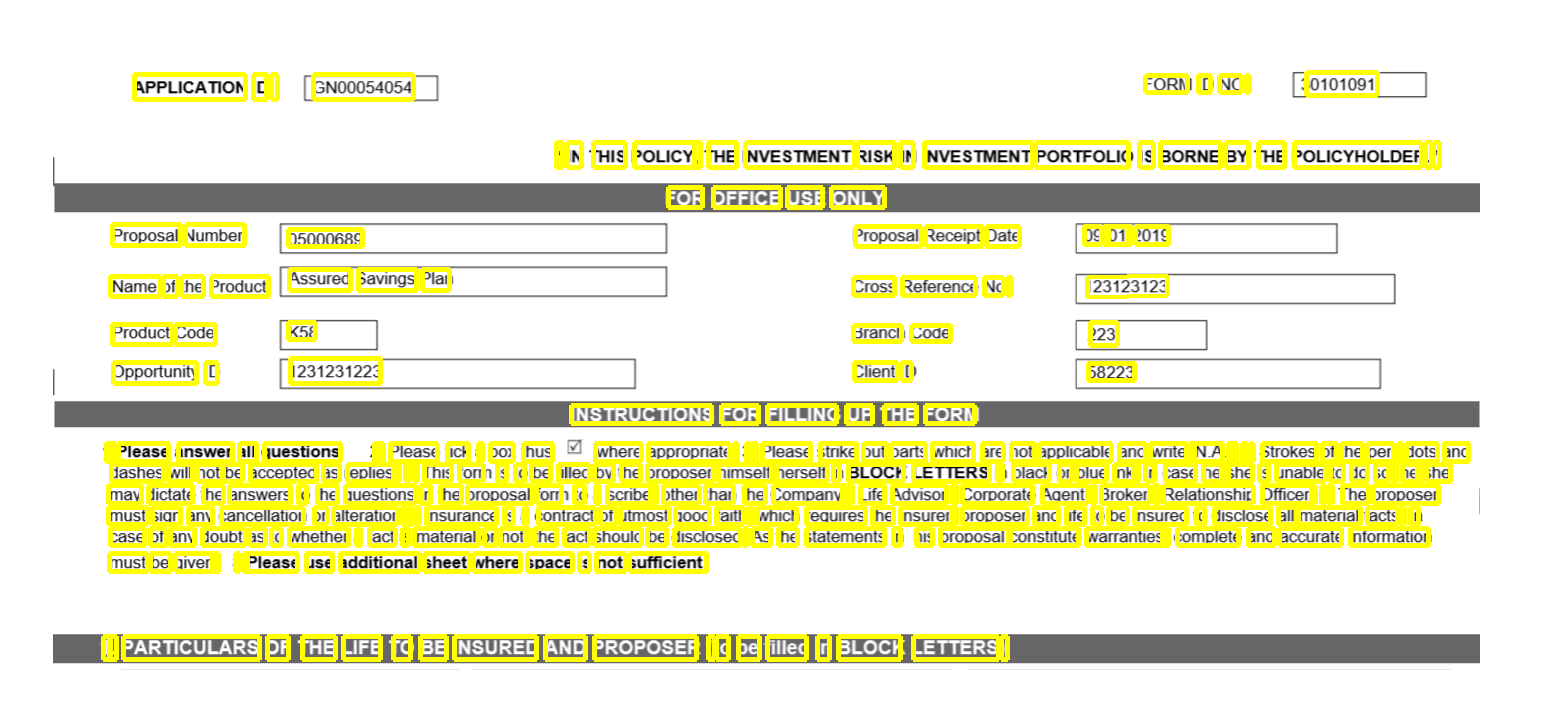

In [80]:
bounds = get_document_bounds(response, FeatureType.WORD)
draw_boxes(image, bounds, 'yellow')

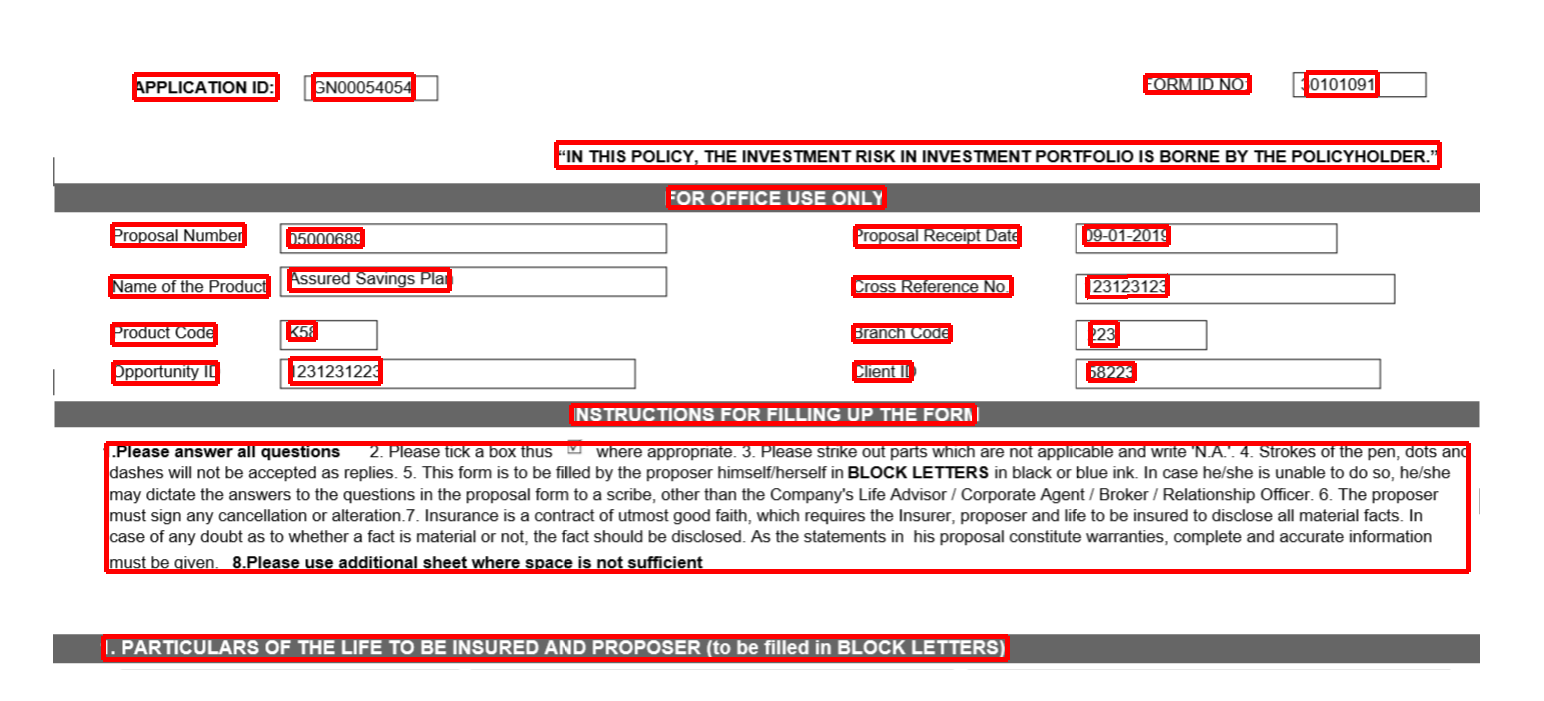

In [81]:
#FOR BLOCKS
bounds = get_document_bounds(response, FeatureType.PARA)
draw_boxes(Image.open(image_file), bounds, 'red')

# Finding location of a single word

In [82]:
def assemble_word(word):
    assembled_word=""
    for symbol in word.symbols:
        assembled_word+=symbol.text
    return assembled_word

def find_word_location(document,word_to_find):
    bounds=[]
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    assembled_word=assemble_word(word)
                    if(assembled_word==word_to_find):
                        bounds.append(word.bounding_box)
    return bounds
find_word_location(document,"APPLICATION")

[vertices {
   x: 134
   y: 74
 }
 vertices {
   x: 245
   y: 74
 }
 vertices {
   x: 245
   y: 99
 }
 vertices {
   x: 134
   y: 99
 }]

# Finding location of multiple words

In [83]:
document

pages {
  property {
    detected_languages {
      language_code: "en"
      confidence: 0.949999988079071
    }
  }
  width: 1544
  height: 701
  blocks {
    bounding_box {
      vertices {
        x: 134
        y: 74
      }
      vertices {
        x: 277
        y: 74
      }
      vertices {
        x: 277
        y: 99
      }
      vertices {
        x: 134
        y: 99
      }
    }
    paragraphs {
      bounding_box {
        vertices {
          x: 134
          y: 74
        }
        vertices {
          x: 277
          y: 74
        }
        vertices {
          x: 277
          y: 99
        }
        vertices {
          x: 134
          y: 99
        }
      }
      words {
        property {
          detected_languages {
            language_code: "en"
          }
        }
        bounding_box {
          vertices {
            x: 134
            y: 74
          }
          vertices {
            x: 245
            y: 74
          }
          vertices {
      

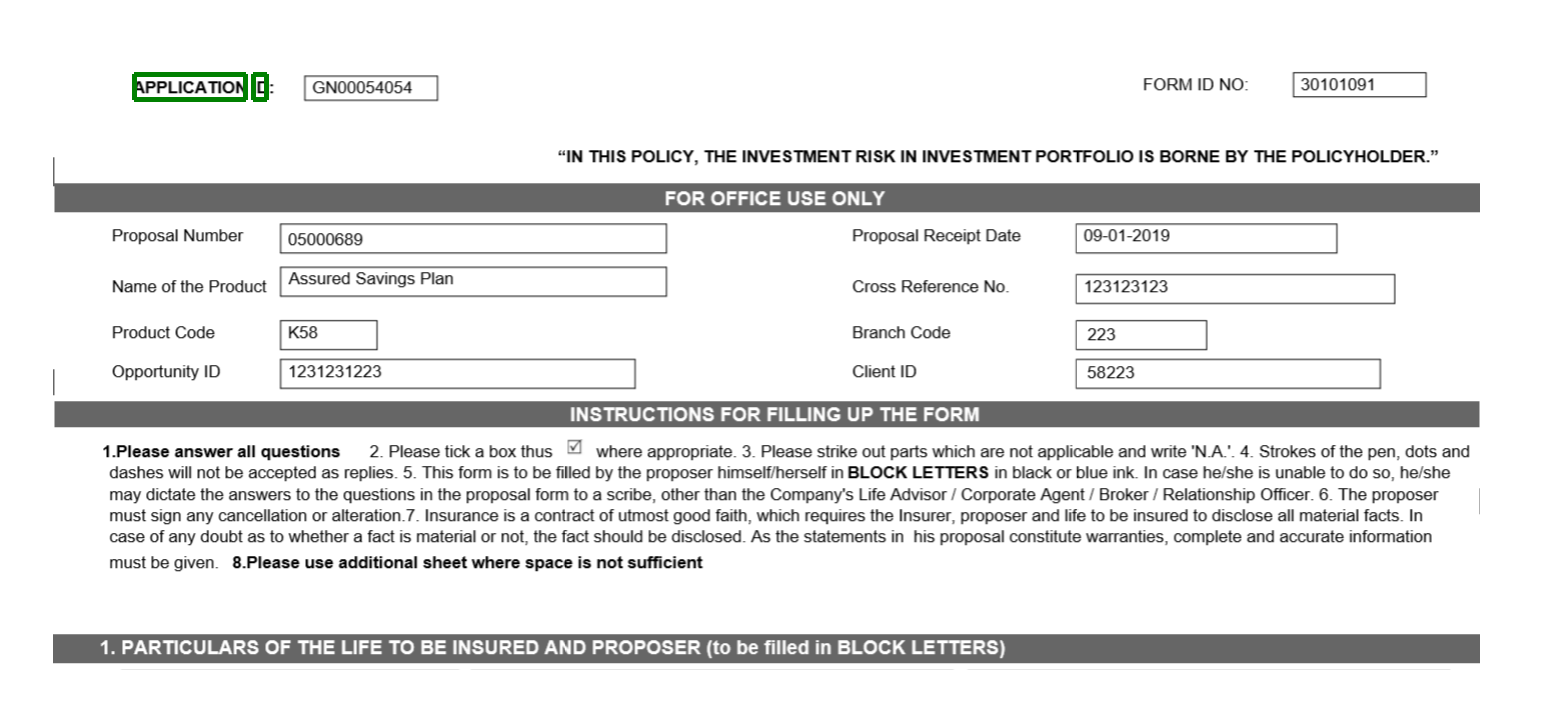

In [84]:
def assemble_word(word):
    assembled_word=""
    for symbol in word.symbols:
        assembled_word+=symbol.text
    return assembled_word

def find_word_location(document,word_to_find,count):
    bounds=[]
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                all_words = paragraph.words
                for i in range(len(all_words)):
                    assembled_word = ""
                    for j in range(count):
                        if(i+j) < len(all_words):
                            assembled_word = assembled_word + assemble_word(all_words[i+j])
                            c=i
#                             print(assembled_word)
                    if(assembled_word==word_to_find):
                        for z in range(count):
                            bounds.append(all_words[c+z].bounding_box)
    return bounds
loc = find_word_location(document,'APPLICATIONID', 2)
draw_boxes(Image.open(image_file), loc, 'green')

### Extract tags and values 

In [85]:
#### cutomize

def get_unique_tags_value(paragraphs, tag):
    out=False
    for i,para in enumerate(paragraphs):
        if(para == tag):
            out = True
            break            
    if out:
        return i
    else:
        return "NA"
    
    
    

def get_paragraph(document):
    breaks = vision.enums.TextAnnotation.DetectedBreak.BreakType
    paragraphs = []
    lines = []

    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                para = ""
                line = ""
                for word in paragraph.words:
                    for symbol in word.symbols:
                        line += symbol.text
                        if symbol.property.detected_break.type == breaks.SPACE:
                            line += ' '
                        if symbol.property.detected_break.type == breaks.EOL_SURE_SPACE:
                            line += ' '
                            lines.append(line)
                            para += line
                            line = ''
                        if symbol.property.detected_break.type == breaks.LINE_BREAK:
                            lines.append(line)
                            para += line
                            line = ''
                paragraphs.append(para)
        return paragraphs

paragraphs = get_paragraph(document)

paragraphs

['APPLICATION ID:',
 'GN00054054',
 'FORM ID NO:',
 '30101091',
 '“IN THIS POLICY, THE INVESTMENT RISK IN INVESTMENT PORTFOLIO IS BORNE BY THE POLICYHOLDER.”',
 'FOR OFFICE USE ONLY',
 'Proposal Number',
 '05000689',
 'Proposal Receipt Date',
 '09-01-2019',
 'Name of the Product',
 'Assured Savings Plan',
 'Cross Reference No.',
 '123123123',
 'Product Code',
 'K58',
 'Branch Code',
 '223',
 'Opportunity ID',
 '1231231223',
 'Client ID',
 '58223',
 'INSTRUCTIONS FOR FILLING UP THE FORM',
 "1.Please answer all questions 2. Please tick a box thus where appropriate. 3. Please strike out parts which are not applicable and write 'NA'. 4. Strokes of the pen, dots and dashes will not be accepted as replies. 5. This form is to be filled by the proposer himself/herself in BLOCK LETTERS in black or blue ink. In case he/she is unable to do so, he/she may dictate the answers to the questions in the proposal form to a scribe, other than the Company's Life Advisor / Corporate Agent/Broker / Relation

## Tags to be extracted

In [86]:
col = ["APPLICATION ID:", "FORM ID NO:", "Proposal Number", "Proposal Receipt Date", "Name of the Product",
                           "Cross Reference No.", "Product Code", "Branch Code",  "Opportunity ID", "Client ID"]

## Save extracted data in dictionary

In [87]:
dict_tag = {}
values = col

for val in values:
    tag = val
    i = get_unique_tags_value(paragraphs, tag)
    if i == "NA":
        print("Tag not found: ", tag)
    else:
        dict_tag[val] = paragraphs[i+1]
dict_tag

{'APPLICATION ID:': 'GN00054054',
 'Branch Code': '223',
 'Client ID': '58223',
 'Cross Reference No.': '123123123',
 'FORM ID NO:': '30101091',
 'Name of the Product': 'Assured Savings Plan',
 'Opportunity ID': '1231231223',
 'Product Code': 'K58',
 'Proposal Number': '05000689',
 'Proposal Receipt Date': '09-01-2019'}

### Save extracted data in csv

In [75]:
df = pd.DataFrame(columns=col)
for tag in col:
    i = get_unique_tags_value(paragraphs, tag)
    if i == "NA":
        print("Tag not found: ", tag)
    else:
        df[tag] = [paragraphs[i+1]]
    
# df.to_csv("claim_2.csv")
df

Tag not found:  Name of the Product
Tag not found:  Cross Reference No.
Tag not found:  Product Code
Tag not found:  Branch Code


,APPLICATION ID:,FORM ID NO:,Proposal Number,Proposal Receipt Date,Name of the Product,Cross Reference No.,Product Code,Branch Code,Opportunity ID,Client ID
0,GN00054054,30101091,05000689,09-01-2019,NaN,NaN,NaN,NaN,1231231223,58223


### Correct form

   Unnamed: 0 APPLICATION ID:  FORM ID NO:  Proposal Number  \
0           0      GN00054054     30101091          5000689   

  Proposal Receipt Date   Name of the Product  Cross Reference No.  \
0            09-01-2019  Assured Savings Plan            123123123   

  Product Code  Branch Code  Opportunity ID  Client ID  
0          K58          223      1231231223      58223  


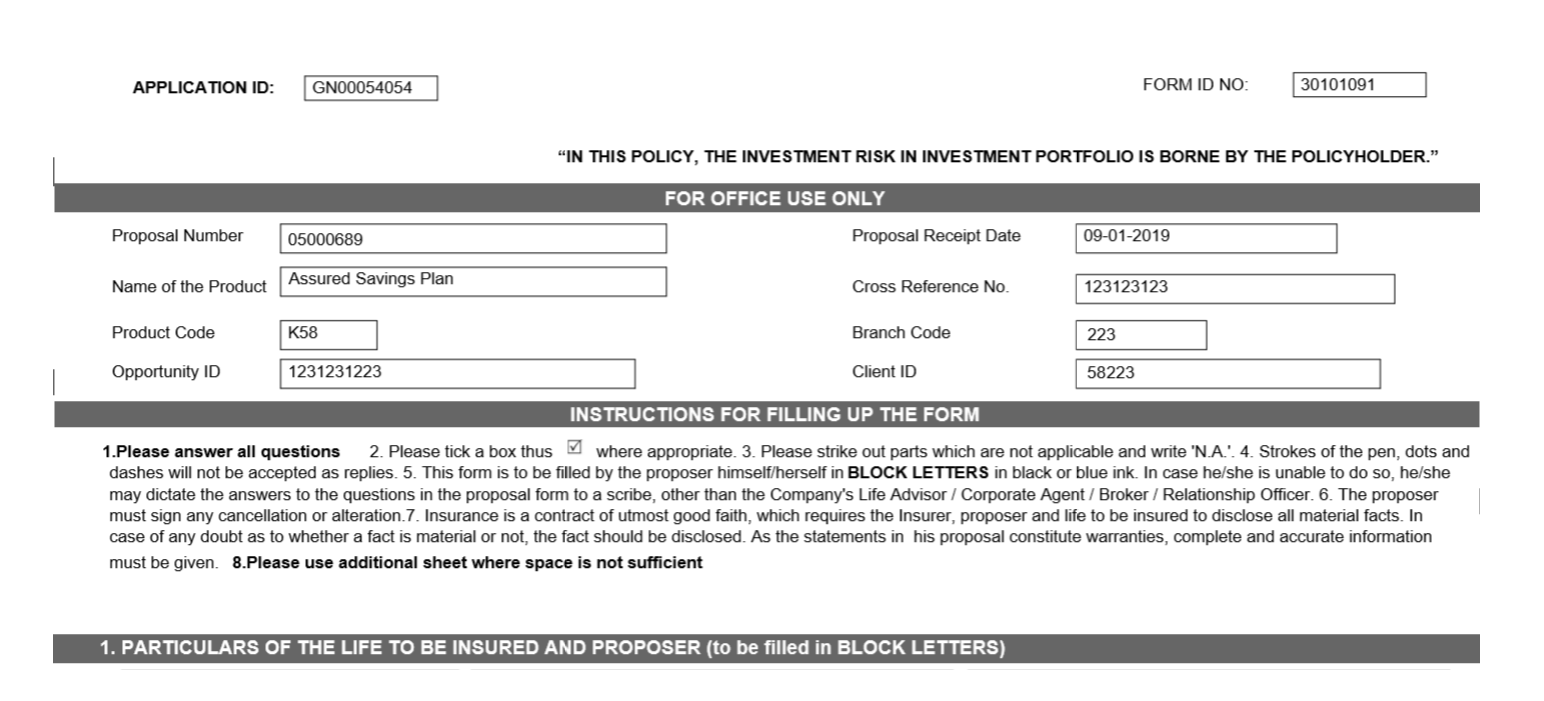

In [62]:
## Correct form
df1=pd.read_csv("claim.csv")
print(df1)
Image.open("img/form.png")

   Unnamed: 0 APPLICATION ID:  FORM ID NO:  Proposal Number  \
0           0      GN00054054     30101091          5000689   

  Proposal Receipt Date  Name of the Product  Cross Reference No.  \
0            09-01-2019                  NaN                  NaN   

   Product Code  Branch Code  Opportunity ID  Client ID  
0           NaN          NaN      1231231223      58223  


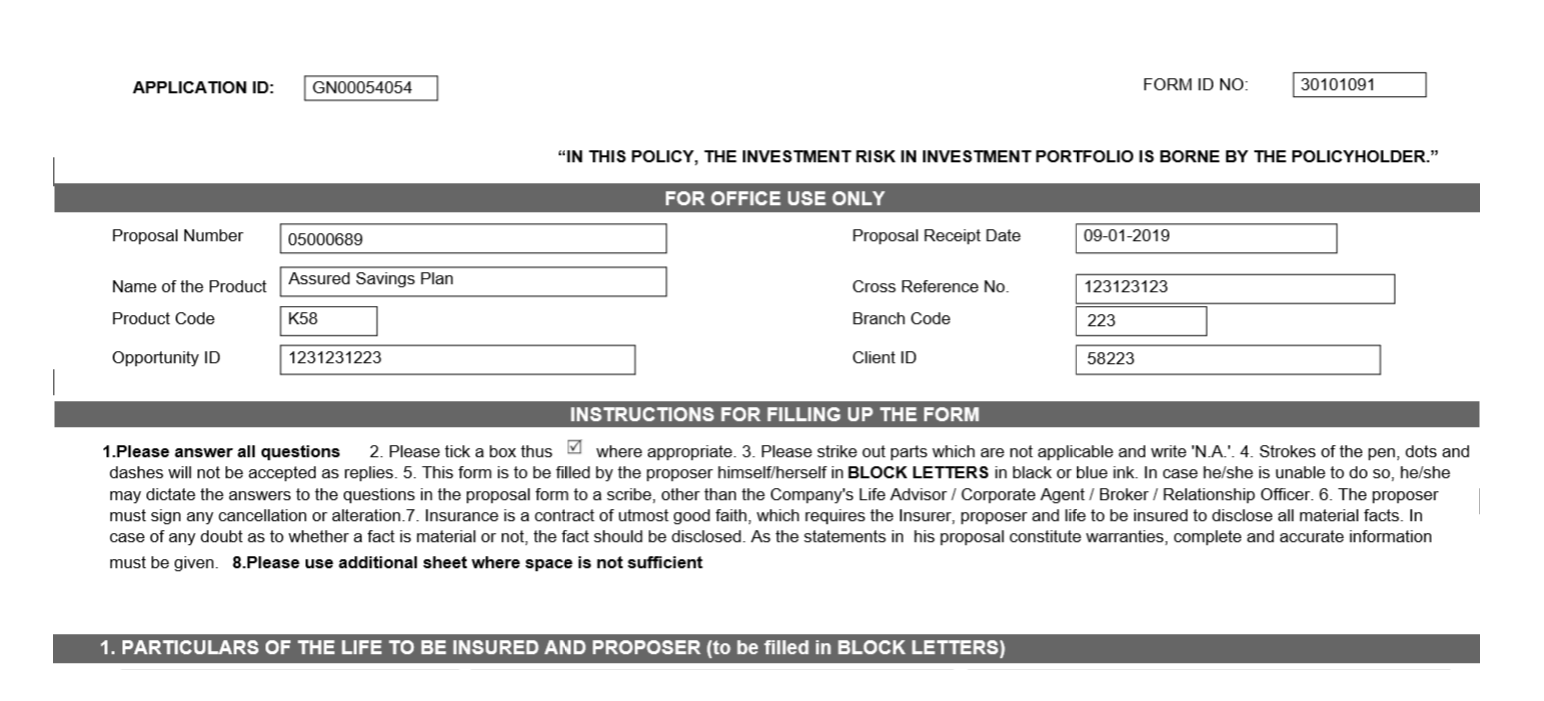

In [63]:
## error form
df1=pd.read_csv("claim_1.csv")
print(df1)
Image.open("img/form_1.png")

In [71]:
### store in key value pair ( dictionary)

,APPLICATION ID:,FORM ID NO:,Proposal Number,Proposal Receipt Date,Name of the Product,Cross Reference No.,Product Code,Branch Code,Opportunity ID,Client ID
0,GN00054054,30101091,05000689,09-01-2019,Assured Savings Plan,123123123,K58,223,1231231223,58223


## Uploading data to BigQuery

Cloud function is triggered when any csv file is uploaded in GCS bucket. This function creates a BigQuery table as per the csv format and updates its values in BigQuery  